# Initial Setup:

### Import Commands:

In [1]:
# Data Parsing:
import numpy as np
import pandas as pd
import time
import re

# General Machine Learning:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from lime.lime_tabular import LimeTabularExplainer

# PyTorch:
import torch
import torch.nn as nn
import torch.nn.functional as F

# BNN models:
from models import *

# Visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Misc.
import warnings

### Options/Config:

In [2]:
# Disable warnings:
warnings.filterwarnings('ignore')

# Use GPU:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Visualization options:
sns.set_theme()
pd.set_option('display.max_columns', None)
ppt_figsize = (18, 4)

Using device: cuda


# Cleaning:

In [3]:
# Load in data:
aviation_df = pd.read_csv('./Datasets/enc_aviation_df.csv')

# Drop non-null rows:
aviation_df = aviation_df.dropna(ignore_index=True)

# Identify/drop non-numeric columns:
print(aviation_df.select_dtypes(exclude=['number']).columns)
aviation_df = aviation_df.select_dtypes(include=['number']).copy()

# Display output:
display(aviation_df)

Index([], dtype='object')


,ev_time,ev_year,ev_month,ev_nr_apt_loc,apt_dist,apt_elev,light_cond,sky_cond_ceil,sky_cond_nonceil,sky_ceil_ht,sky_nonceil_ht,vis_sm,wx_temp,wx_dew_pt,wind_dir_deg,gust_kts,altimeter,Injury,wx_cond_basic,Damage,cert_max_gr_wt,acft_category,homebuilt,total_seats,num_eng,fixed_retractable,type_last_insp,afm_hrs_last_insp,afm_hrs,cat_Aircraft,cat_Personnel,cat_Environmental,cat_Organization,cat_NotDetermined,crew_no,med_certf,Owner_Type,Fac_Use,Region_AAL,Region_ACE,Region_AEA,Region_AGL,Region_ANE,Region_ANM,Region_ASO,Region_ASW,Region_AWP
0,1303.0,2008,1,1.0,0.0,10.0,2.0,2.0,1.0,0.0,0.0,10.0,134.6,89.6,80.0,0.0,30.190001,1,1.0,1,2400.0,1,0.0,4.0,1.0,1.0,3.0,75,2865.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0,0,0,0,0,0,0,0,1
1,1303.0,2008,1,1.0,0.0,10.0,2.0,2.0,1.0,0.0,0.0,10.0,134.6,89.6,80.0,0.0,30.190001,1,1.0,2,1960.0,1,0.0,2.0,1.0,1.0,4.0,8760,340.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0,0,0,0,0,0,0,0,1
2,474.0,2008,1,1.0,0.0,1299.0,6.0,2.0,1.0,0.0,0.0,10.0,32.0,32.0,170.0,0.0,30.639999,3,1.0,1,9920.0,1,0.0,9.0,1.0,1.0,0.0,0,1871.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0,0,0,0,0,0,0,1,0
3,1273.0,2008,1,1.0,0.0,68.0,2.0,2.0,1.0,0.0,0.0,10.0,131.0,57.2,360.0,20.0,30.620001,1,1.0,2,2850.0,1,0.0,2.0,1.0,1.0,3.0,2928,516.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,1.0,0,0,0,0,0,0,0,1,0
4,863.0,2008,1,0.0,5.0,8.0,2.0,2.0,1.0,0.0,0.0,10.0,163.4,138.2,100.0,0.0,30.290001,1,1.0,2,2332.0,1,0.0,4.0,1.0,1.0,1.0,52,7059.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28291,1379.0,2025,2,1.0,0.0,44.0,0.0,2.0,1.0,0.0,0.0,10.0,145.4,122.0,260.0,0.0,30.020000,1,1.0,2,5480.0,1,0.0,4.0,1.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,1
28292,1063.0,2025,2,1.0,0.0,1494.0,0.0,2.0,1.0,0.0,0.0,10.0,113.0,93.2,320.0,0.0,30.240000,1,1.0,2,2148.2,0,0.0,0.0,6.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0,0,0,0,1,0,0,0
28293,1213.0,2025,2,1.0,0.0,2645.0,0.0,3.0,0.0,300.0,0.0,9.0,86.0,86.0,90.0,0.0,30.180000,1,1.0,2,5480.0,1,0.0,4.0,1.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0,0,0,0,1,0,0,0
28294,958.0,2025,2,1.0,1.0,1618.0,0.0,2.0,1.0,0.0,0.0,10.0,113.0,82.4,260.0,23.0,29.400000,1,1.0,2,5480.0,1,0.0,4.0,1.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0,0,1,0,0,0,0,0


# Feature Engineering:

In [4]:
def variable_splitter(input_df, target_feature='Damage'):
    # Identify variables:
    #X = input_df.drop(columns=['damage', 'ev_highest_injury'])
    X = input_df.drop(columns=['Damage', 'Injury'])
    y = input_df[target_feature]

    # Train-test split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=28980)

    # Columns to scale:
    cols_to_scale = ['ev_time', 'ev_year', 'apt_elev', 'sky_ceil_ht', 'vis_sm',
                     'wx_temp', 'wx_dew_pt', 'wind_dir_deg', 'gust_kts', 'altimeter',
                     'cert_max_gr_wt', 'afm_hrs_last_insp', 'afm_hrs']

    # Standardize only the selected columns:
    scaler_X = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[cols_to_scale] = scaler_X.fit_transform(X_train[cols_to_scale])
    X_test_scaled[cols_to_scale] = scaler_X.transform(X_test[cols_to_scale])

    # Encode labels properly for multiclass classification:
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Convert to PyTorch tensors (both train & test):
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

X_train, X_test, y_train, y_test = variable_splitter(aviation_df, target_feature='Damage')

# Modeling:

### Model Parameters:

In [ ]:
# Use weighted CrossEntropy:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.cpu().numpy())
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Model parameters:
learn_rates = [1, 0.1, 0.01, 0.001, 0.0001,]
epochs = 1000
model_filepaths = []

# Save model results:
model_results_df = pd.DataFrame()

# Get number of unique classes:
num_classes = len(torch.unique(y_train))

# Numbers of dimensions:
dimension_list = [10, 50, 100, 500]

# Best success metrics:
best_val_f1 = 0.0
best_model_weights = None

# Different Activation Functions:
activation_funcs = [F.relu,
                    F.leaky_relu,
                    F.elu,
                    F.sigmoid,
                    F.silu,
                    ]

### Training Loop:

In [ ]:
%%time
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test both target variables:
for target in ['Damage', 'Injury']:
    # Train-test split based on target feature:
    X_train, X_test, y_train, y_test = variable_splitter(aviation_df, target)

    # Move data to device
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

    # Different activation functions:
    for activation in activation_funcs:
        act_name = activation.__name__
        for dimensions in dimension_list:

            model_list = [
                MLP(input_dim=X_train.shape[1], hidden_dim=dimensions, output_dim=num_classes, activation_fn=activation),
                SimpleBNN(input_dim=X_train.shape[1], hidden_dim=dimensions, output_dim=num_classes, activation_fn=activation),
                DropoutBNN(input_dim=X_train.shape[1], hidden_dim=dimensions, output_dim=num_classes, dropout_p=0.5, activation_fn=activation),
                AttentionBNN(input_dim=X_train.shape[1], hidden_dim=dimensions, output_dim=num_classes, activation_fn=activation),
                GraphBNN(input_dim=X_train.shape[1], hidden_dim=dimensions, output_dim=num_classes, activation_fn=activation),
            ]

            for learn_rate in learn_rates:
                for model in model_list:
                    net_name = model.__class__.__name__
                    model = model.to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

                    for epoch in range(epochs):
                        # === Training Phase ===
                        model.train()
                        optimizer.zero_grad()

                        logits_train, confidence_train, prediction_train = model(X_train)
                        loss_train = criterion(logits_train, y_train)
                        loss_train.backward()
                        optimizer.step()

                        # Compute Training Metrics
                        train_f1 = f1_score(
                            y_train.cpu().numpy(),
                            prediction_train.detach().cpu().numpy(),
                            average='macro',
                        )

                        # === Testing Phase ===
                        model.eval()
                        with torch.no_grad():
                            logits_test, confidence_test, prediction_test = model(X_test)
                            loss_test = criterion(logits_test, y_test)

                        test_f1 = f1_score(
                            y_test.cpu().numpy(),
                            prediction_test.cpu().numpy(),
                            average='macro',
                        )

                        avg_confidence = confidence_train.detach().cpu().numpy().mean()

                        modelFQPN = f'./Models/{target}_{net_name}_{act_name}_Epoch{epoch + 1}_LR{learn_rate:.0e}_Dim{dimensions}.pt'

                        temp_df = pd.DataFrame({
                            'Model': [net_name],
                            'Target': [target],
                            'Epoch': [epoch + 1],
                            'LR': [learn_rate],
                            'Dimensions': [dimensions],
                            'Activation': [act_name],
                            'Train_Loss': [loss_train.item()],
                            'Test_Loss': [loss_test.item()],
                            'Train_F1': [train_f1],
                            'Test_F1': [test_f1],
                            'Confidence': [avg_confidence],
                            'FQPN': [modelFQPN],
                        })
                        model_results_df = pd.concat([model_results_df, temp_df], ignore_index=True)

                        torch.save(model.state_dict(), modelFQPN)

# Save results
model_results_df.to_csv('./Model_Results.csv', index=False)

# Display sorted by Test_F1
model_results_df = model_results_df.sort_values(by='Test_F1', ascending=False)
display(model_results_df)

In [ ]:
print('\nBest F1-Scores:')
display(model_results_df.sort_values(by='Test_F1', ascending=False).head(5))

print('\nLowest Loss:')
display(model_results_df.sort_values(by='Test_Loss', ascending=True).head(5))

# Optimal Models:

### Subset to `Injury` or `Damage`:

In [5]:
# Load results DataFrame:
model_results_df = pd.read_csv('./Final_Model_Results.csv')
model_results_df = model_results_df[model_results_df['Model'].isin(['AttentionBNN', 'DropoutBNN'])]
model_results_df = model_results_df.sort_values(by='Test_F1', ascending=False)
aviation_df = pd.read_csv('./Datasets/enc_aviation_df.csv')
# Display data:
display(model_results_df)

,Model,Target,Epoch,LR,Dimensions,Activation,Train_Loss,Test_Loss,Train_F1,Test_F1,Confidence,FQPN
229722,DropoutBNN,Damage,723,0.01,500,elu,4.426924e-01,3.991097e+00,0.707342,0.616788,0.858122,./Models/Damage_DropoutBNN_elu_Epoch723_LR1e-0...
229741,DropoutBNN,Damage,742,0.01,500,elu,4.081219e-01,4.490259e+00,0.703202,0.615564,0.853148,./Models/Damage_DropoutBNN_elu_Epoch742_LR1e-0...
149358,DropoutBNN,Damage,359,0.01,500,leaky_relu,3.411471e-01,1.184539e+01,0.744468,0.613742,0.878809,./Models/Damage_DropoutBNN_leaky_relu_Epoch359...
229292,DropoutBNN,Damage,293,0.01,500,elu,5.059066e-01,4.197130e+00,0.710062,0.611623,0.879904,./Models/Damage_DropoutBNN_elu_Epoch293_LR1e-0...
229089,DropoutBNN,Damage,90,0.01,500,elu,4.437361e-01,4.494297e+00,0.698033,0.611205,0.852200,./Models/Damage_DropoutBNN_elu_Epoch90_LR1e-02...
...,...,...,...,...,...,...,...,...,...,...,...,...
262003,AttentionBNN,Damage,4,1.00,50,sigmoid,3.663495e+04,2.072529e+04,0.298233,0.051416,1.000000,./Models/Damage_AttentionBNN_sigmoid_Epoch4_LR...
302121,AttentionBNN,Damage,122,1.00,500,sigmoid,7.606104e+06,2.832439e+07,0.092456,0.051416,1.000000,./Models/Damage_AttentionBNN_sigmoid_Epoch122_...
102002,AttentionBNN,Damage,3,1.00,50,leaky_relu,9.410236e+04,2.779358e+05,0.064365,0.051416,1.000000,./Models/Damage_AttentionBNN_leaky_relu_Epoch3...
62003,AttentionBNN,Damage,4,1.00,500,relu,1.683474e+08,5.670442e+07,0.064365,0.051357,1.000000,./Models/Damage_AttentionBNN_relu_Epoch4_LR1e+...


### Predictions:

In [6]:
# Get the best models per Model-Target combo
best_results = model_results_df.loc[model_results_df.groupby(['Model', 'Target'])['Test_F1'].idxmax()]

def get_activation_fn(name):
    '''Returns the correct activation function instance from a string.'''
    name = name.lower()
    activation_map = {
        'relu': torch.nn.ReLU,
        'leaky_relu': torch.nn.LeakyReLU,
        'elu': torch.nn.ELU,
        'sigmoid': torch.nn.Sigmoid,
        'tanh': torch.nn.Tanh,
        'silu': torch.nn.SiLU,
    }
    if name not in activation_map:
        raise ValueError(f'Unsupported activation function: {name}')
    return activation_map[name]()

predictions_df = pd.DataFrame()

# Separate by target
for target in ['Injury', 'Damage',]:
    aviation_df = aviation_df.drop(columns=[col for col in aviation_df.columns if '_prediction' in col or '_confidence' in col], errors='ignore')

    # Get test data
    X_train, X_test, y_train, y_test = variable_splitter(aviation_df, target)

    # Combine train and test for full dataset
    X = torch.cat((X_train, X_test), dim=0)
    y = torch.cat((y_train, y_test), dim=0)

    # Filter best models for current target
    target_models = best_results[best_results['Target'] == target]

    for _, row in target_models.iterrows():
        model_name = row['Model']
        activation_fn = get_activation_fn(row['Activation'])
        dim = int(row['Dimensions'])
        epoch = int(row['Epoch'])
        lr = row['LR']

        # Build model
        model_cls = globals()[model_name]
        model = model_cls(
            input_dim=X_test.shape[1],
            hidden_dim=dim,
            output_dim=len(set(y_train.numpy())),
            activation_fn=activation_fn
        )

        # Load saved model weights
        if lr == 1.0:
            lr = 1

        model_path = f'./Models/{target}_{model_name}_{row['Activation']}_Epoch{epoch}_LR{lr:.0e}_Dim{dim}.pt'
        model.load_state_dict(torch.load(model_path))
        model.eval()

        # Predict on full dataset
        with torch.no_grad():
            logits, _, _ = model(X)
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

        # Save predictions and confidence
        predictions_df[f'{target}_prediction'] = preds.cpu().numpy()
        predictions_df[f'{target}_confidence'] = torch.max(probs, dim=1).values.cpu().numpy()

# Combine predictions with aviation_df:
aviation_df = pd.concat([aviation_df, predictions_df], axis=1)

# Save updated DataFrame
aviation_df.to_csv('./Aviation_Predictions.csv', index=False)

### Classification Reports:

In [12]:
# Get the best models per Model-Target combo
best_results = model_results_df.loc[model_results_df.groupby(['Model', 'Target'])['Test_F1'].idxmax()]

# Separate by target:
for target in ['Injury', 'Damage']:
    aviation_df = aviation_df.drop(columns=[col for col in aviation_df.columns if '_prediction' in col or '_confidence' in col], errors='ignore')

    # Get train/test data:
    X_train, X_test, y_train, y_test = variable_splitter(aviation_df, target)

    # Combine for full dataset:
    X = torch.cat((X_train, X_test), dim=0)
    y = torch.cat((y_train, y_test), dim=0)

    # Filter for best models for current target:
    target_models = best_results[best_results['Target'] == target]

    for _, row in target_models.iterrows():
        model_name = row['Model']
        activation_fn = get_activation_fn(row['Activation'])
        dim = int(row['Dimensions'])
        epoch = int(row['Epoch'])
        lr = row['LR']

        # Instantiate model:
        model_cls = globals()[model_name]
        model = model_cls(
            input_dim=X_test.shape[1],
            hidden_dim=dim,
            output_dim=len(set(y_train.numpy())),
            activation_fn=activation_fn
        )

        # Load saved weights:
        if lr == 1.0:
            lr = 1
        model_path = f"./Models/{target}_{model_name}_{row['Activation']}_Epoch{epoch}_LR{lr:.0e}_Dim{dim}.pt"
        model.load_state_dict(torch.load(model_path))
        model.eval()

        # Predictions:
        with torch.no_grad():
            train_logits, _, train_preds = model(X_train)
            test_logits, _, test_preds = model(X_test)
            full_logits, _, full_preds = model(X)

            probs = torch.nn.functional.softmax(full_logits, dim=1)
            preds = torch.argmax(probs, dim=1)

        # Print classification reports:
        print(f'\n\nModel: {model_name} | Target: {target}')
        print('Training:')
        print(classification_report(y_train.numpy(), train_preds.numpy()))
        print('Test:')
        print(classification_report(y_test.numpy(), test_preds.numpy()))
        print('Full:')
        print(classification_report(y.numpy(), full_preds.numpy()))

        # Save predictions & confidence:
        predictions_df[f'{target}_prediction'] = preds.cpu().numpy()
        predictions_df[f'{target}_confidence'] = torch.max(probs, dim=1).values.cpu().numpy()

# Append predictions:
aviation_df = pd.concat([aviation_df, predictions_df], axis=1)

# Save:
aviation_df.to_csv('./Aviation_Predictions.csv', index=False)



Model: AttentionBNN | Target: Injury
Training:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81     15639
           1       0.29      0.01      0.01      2477
           2       0.34      0.15      0.21      4520

    accuracy                           0.68     22636
   macro avg       0.45      0.36      0.34     22636
weighted avg       0.59      0.68      0.60     22636

Test:
              precision    recall  f1-score   support

           0       0.70      0.94      0.81      3910
           1       0.57      0.01      0.01       619
           2       0.32      0.12      0.18      1131

    accuracy                           0.67      5660
   macro avg       0.53      0.36      0.33      5660
weighted avg       0.61      0.67      0.59      5660

Full:
              precision    recall  f1-score   support

           0       0.74      0.53      0.61     19549
           1       0.13      0.37      0.19      3096
           2  

# BNN Feature Importances:

### Compute Importances

In [13]:
# Clear any potential predictions:
aviation_df = aviation_df.drop(columns=[col for col in aviation_df.columns if '_prediction' in col or '_confidence' in col], errors='ignore')

# Load results DataFrame
model_results_df = pd.read_csv('./Final_Model_Results.csv')

# Filter for only AttentionBNN/Injury and DropoutBNN/Damage
model_results_df = model_results_df.loc[
    ((model_results_df['Model'] == 'AttentionBNN') & (model_results_df['Target'] == 'Injury')) |
    ((model_results_df['Model'] == 'DropoutBNN') & (model_results_df['Target'] == 'Damage'))
]

# Get the best result for each combo
best_results = model_results_df.loc[model_results_df.groupby(['Model', 'Target'])['Test_F1'].idxmax()]
best_results = best_results.sort_values(by='Test_F1', ascending=False)

# Activation lookup
def get_activation_fn(name):
    name = name.lower()
    activation_map = {
        'relu': torch.nn.ReLU,
        'leaky_relu': torch.nn.LeakyReLU,
        'elu': torch.nn.ELU,
        'sigmoid': torch.nn.Sigmoid,
        'tanh': torch.nn.Tanh,
        'silu': torch.nn.SiLU,
    }
    return activation_map[name]()

# Dictionary to store importances:
importances_dict = {}

# Loop over filtered models
for _, row in best_results.iterrows():
    target = row['Target']
    model_name = row['Model']
    activation_fn = get_activation_fn(row['Activation'])
    dim = int(row['Dimensions'])
    epoch = int(row['Epoch'])
    lr = row['LR']

    # Load data
    X_train, X_test, y_train, y_test = variable_splitter(aviation_df, target)
    X_train_np = X_train.cpu().numpy()
    X_test_np = X_test.cpu().numpy()
    feature_names = aviation_df.drop(columns=['Damage', 'Injury']).columns.tolist()

    model_cls = globals()[model_name]
    model = model_cls(
        input_dim=X_test.shape[1],
        hidden_dim=dim,
        output_dim=len(set(y_train.numpy())),
        activation_fn=activation_fn
    ).to(device)

    # Format LR correctly for filename
    lr_str = f'{int(lr)}' if lr == 1.0 else f'{lr:.0e}'
    model_path = f'./Models/{target}_{model_name}_{row['Activation']}_Epoch{epoch}_LR{lr_str}_Dim{dim}.pt'
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # === LIME ===
    def predict_proba_fn(x_numpy):
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
        with torch.no_grad():
            logits, _, _ = model(x_tensor)
            probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.cpu().numpy()

    explainer = LimeTabularExplainer(
        training_data=X_train_np,
        feature_names=feature_names,
        class_names=[str(i) for i in range(len(set(y_train.cpu().numpy())))],
        mode='classification'
    )

    # Explain for each class (0, 1, 2)
    for class_label in [0, 1, 2]:
        explanation = explainer.explain_instance(X_test_np[0], predict_proba_fn, num_features=10, labels=[class_label])
        importance_dict = dict(explanation.as_list(label=class_label))
        importances_dict[f'{target}_{class_label}'] = importance_dict

    print(model_path)

# Print all importances
for key in importances_dict:
    print(f'{key}: {importances_dict[key]}')

./Models/Damage_DropoutBNN_elu_Epoch723_LR1e-02_Dim500.pt
./Models/Injury_AttentionBNN_sigmoid_Epoch675_LR1e-03_Dim500.pt
Damage_0: {'ev_month <= 4.00': 0.014481082602916553, 'sky_nonceil_ht > 0.00': -0.005974629453117956, 'med_certf <= 0.00': 0.005937110973803514, 'apt_dist <= 0.00': 0.005572894868861356, 'sky_cond_nonceil > 1.00': -0.005100578534614665, 'vis_sm <= -0.01': 0.004688209981413294, '0.60 < ev_nr_apt_loc <= 1.00': -0.004477431253719856, 'Region_ACE <= 0.00': 0.004198855327795367, 'total_seats > 4.00': -0.003896680735804566, 'cat_NotDetermined <= 0.00': 0.0033151223701039074}
Damage_1: {'cert_max_gr_wt > -0.07': -0.15967460273632153, 'sky_nonceil_ht > 0.00': 0.10531290066684403, 'apt_dist <= 0.00': -0.0918870513885167, 'total_seats > 4.00': 0.08762634969783537, 'vis_sm <= -0.01': -0.07287629704746824, 'afm_hrs > 0.04': 0.052227669523958326, '0.60 < ev_nr_apt_loc <= 1.00': 0.04488281546228529, 'ev_month <= 4.00': -0.044362275066925236, 'type_last_insp > 3.00': -0.04274668807

### Damage - DropoutBNN

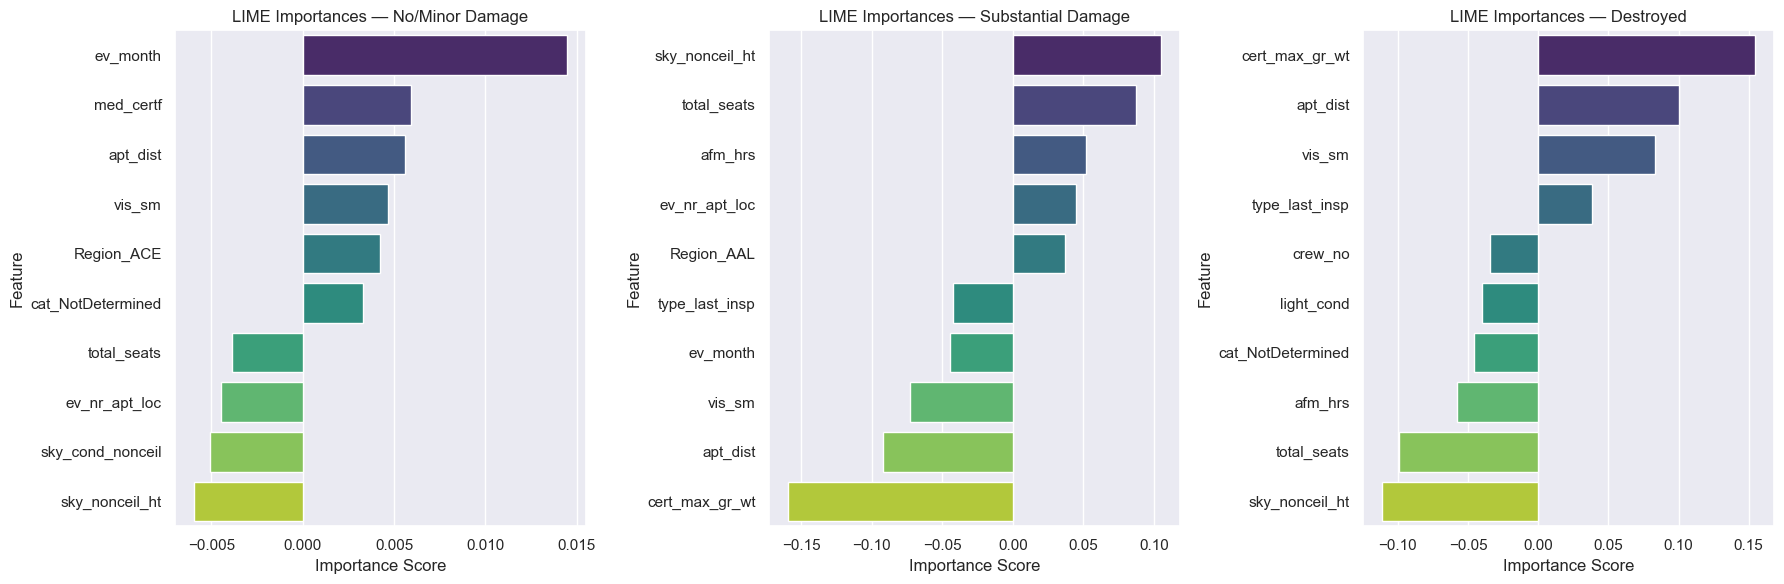

In [14]:
# Extract and plot feature importances for Damage classes 0, 1, and 2
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
class_labels = ['Damage_0', 'Damage_1', 'Damage_2']
titles = ['No/Minor Damage', 'Substantial Damage', 'Destroyed']

for i, class_label in enumerate(class_labels):
    # Extract clean feature names using regex
    cleaned = []
    for raw_feat, imp in importances_dict[class_label].items():
        match = re.search(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b', raw_feat)
        feature_only = match.group(1) if match else raw_feat
        cleaned.append((feature_only, imp))

    # Convert to DataFrame and sort by actual importance
    df = pd.DataFrame(cleaned, columns=['Feature', 'Importance'])
    df = df.sort_values(by='Importance', ascending=False)

    # Plot on respective subplot
    sns.barplot(data=df, x='Importance', y='Feature', palette='viridis', ax=axes[i])
    axes[i].set_title(f'LIME Importances — {titles[i]}')
    axes[i].set_xlabel('Importance Score')
    axes[i].set_ylabel('Feature')

plt.tight_layout()
plt.show()

### Injury - AttentionBNN

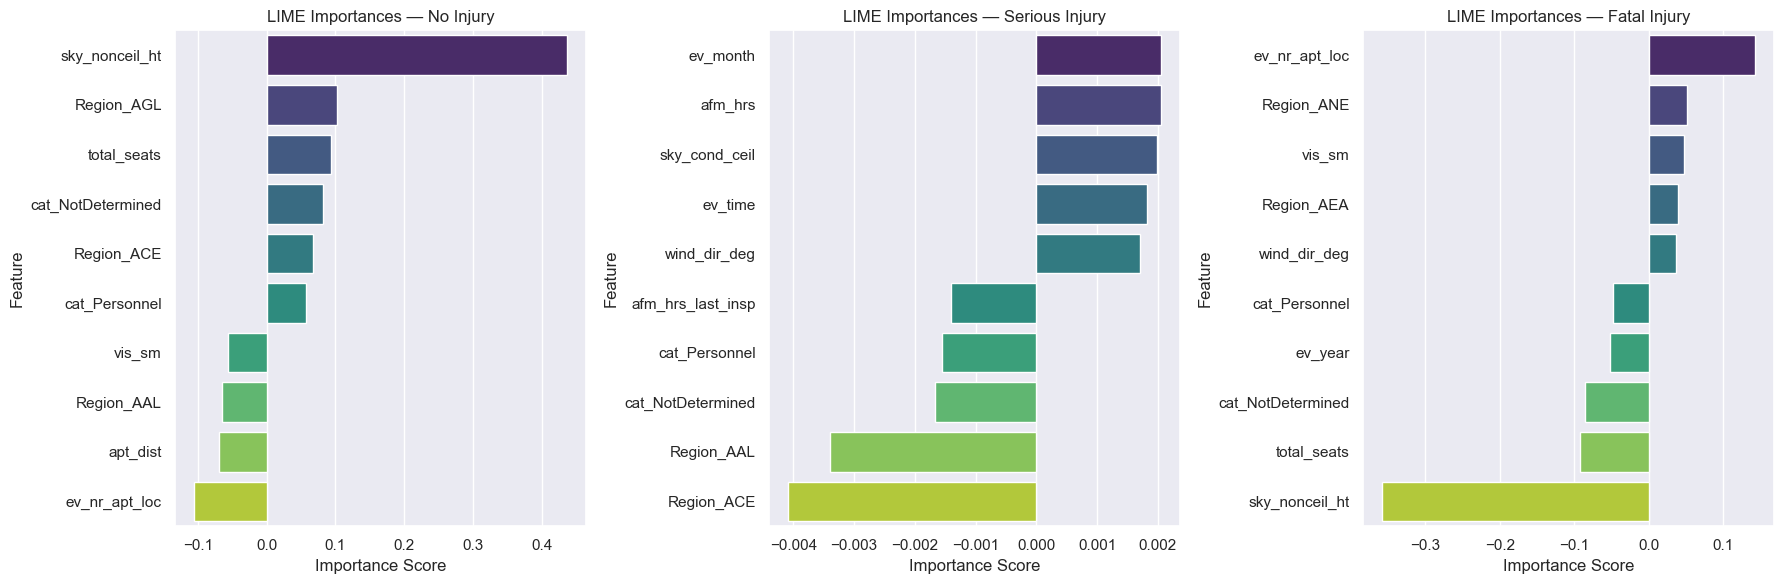

In [15]:
# Extract and plot feature importances for Injury classes 0, 1, and 2
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
class_labels = ['Injury_0', 'Injury_1', 'Injury_2']
titles = ['No Injury', 'Serious Injury', 'Fatal Injury']

# Print model name:

for i, class_label in enumerate(class_labels):
    # Extract clean feature names using regex
    cleaned = []
    for raw_feat, imp in importances_dict[class_label].items():
        match = re.search(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b', raw_feat)
        feature_only = match.group(1) if match else raw_feat
        cleaned.append((feature_only, imp))

    # Convert to DataFrame and sort by actual importance
    plot_df = pd.DataFrame(cleaned, columns=['Feature', 'Importance'])
    plot_df = plot_df.sort_values(by='Importance', ascending=False)

    # Plot on respective subplot
    sns.barplot(data=plot_df, x='Importance', y='Feature', palette='viridis', ax=axes[i])
    axes[i].set_title(f'LIME Importances — {titles[i]}')
    axes[i].set_xlabel('Importance Score')
    axes[i].set_ylabel('Feature')

plt.tight_layout()
plt.show()